### Neural network hidden layer size experiments, summary across all genes

We want to see whether smaller models (i.e. models with smaller hidden layer sizes) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results across all genes in our cancer driver gene set.

In [1]:
import os
import glob
from math import ceil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_ccle_nn_hsize_range'
)

num_genes = 16042
seed = 42

output_plots = True
output_plots_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'generalization_plots', 'nn_results'
)

### Get performance information for each gene and hidden layer size

In [3]:
hsize_df = []

for gene_dir in glob.glob(os.path.join(results_dir, '*')):
    gene = os.path.basename(gene_dir)
    for results_file in glob.glob(
        os.path.join(
            results_dir,
            gene,
            f'{gene}_signal_mad_s{seed}_n{num_genes}_h*_classify_metrics.tsv.gz'
        )
    ):
        hsize = (
            os.path.basename(results_file).split('_')[5].replace('h', '')
        )
        hsize_gene_df = (
            pd.read_csv(results_file, sep='\t', index_col=0)
              .reset_index(drop=True)
              .drop(columns='holdout_cancer_type')
        )
        hsize_gene_df['hsize'] = hsize
        hsize_df.append(hsize_gene_df)

hsize_df = pd.concat(hsize_df)
print(hsize_df.gene.unique().shape)
print(np.sort(hsize_df.gene.unique()))
hsize_df.head()

(71,)
['ABL1' 'ALK' 'APC' 'ARID1A' 'ARID1B' 'ARID2' 'ASXL1' 'ATM' 'ATRX' 'AXIN1'
 'BAP1' 'BCOR' 'BRAF' 'BRCA2' 'CARD11' 'CASP8' 'CDH1' 'CDKN2A' 'CIC'
 'CREBBP' 'CSF1R' 'CTNNB1' 'DNMT1' 'EGFR' 'EP300' 'ERBB2' 'EZH2' 'FBXW7'
 'FGFR2' 'FGFR3' 'FLT3' 'FOXL2' 'FUBP1' 'GATA2' 'GNAQ' 'GNAS' 'IDH1'
 'IDH2' 'JAK1' 'JAK2' 'KDM5C' 'KDM6A' 'KIT' 'KRAS' 'MED12' 'MET' 'NCOR1'
 'NF1' 'NF2' 'NFE2L2' 'NOTCH1' 'NOTCH2' 'NPM1' 'NRAS' 'PBRM1' 'PDGFRA'
 'PIK3CA' 'PTEN' 'RB1' 'RNF43' 'SETBP1' 'SETD2' 'SF3B1' 'SMAD2' 'SMAD4'
 'SMARCA4' 'SOX9' 'STAG2' 'STK11' 'TP53' 'VHL']


,aupr,gene,signal,seed,data_type,fold,hsize
0,0.98176,TP53,signal,42,train,0,4
1,0.88494,TP53,signal,42,test,0,4
2,0.87921,TP53,signal,42,cv,0,4
3,0.99779,TP53,signal,42,train,1,4
4,0.91229,TP53,signal,42,test,1,4


### Plot average performance for each hidden layer size, across genes/seeds/folds

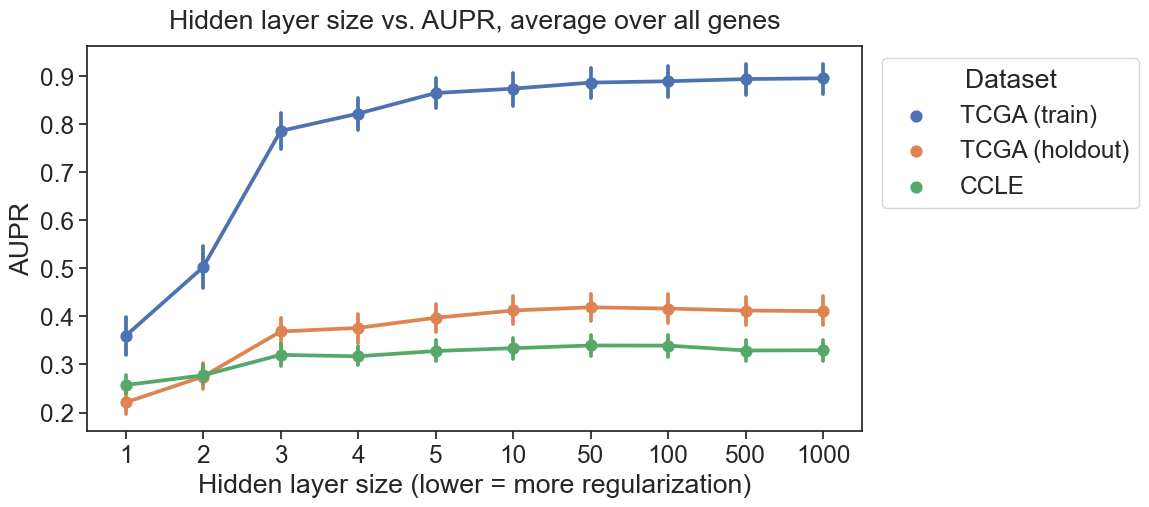

In [4]:
# plot hidden layer size as a categorical variable vs. performance
sns.set({'figure.figsize': (10, 5)})
sns.set_style('ticks')

plot_df = (hsize_df
    .sort_values(by=['hsize'])
    .reset_index(drop=True)
)
plot_df.hsize = plot_df.hsize.astype(int)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.pointplot(
        data=plot_df,
        x='hsize', y='aupr', hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set_xlabel(f'Hidden layer size (lower = more regularization)')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Hidden layer size vs. AUPR, average over all genes', y=1.025)

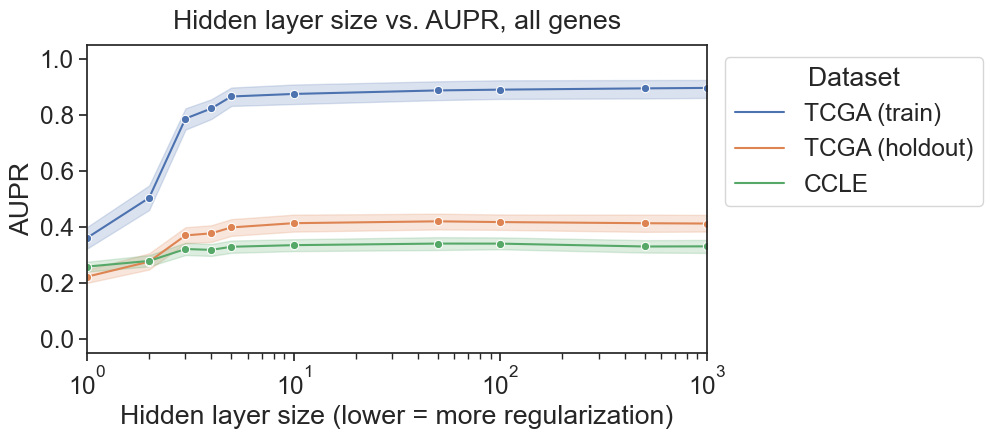

In [5]:
# plot hidden layer size as a float-valued variable (on a log scale) vs. performance
sns.set({'figure.figsize': (8, 4)})
sns.set_style('ticks')

plot_df = (hsize_df
    .sort_values(by=['hsize'])
    .reset_index(drop=True)
)
plot_df.hsize = plot_df.hsize.astype(int)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=plot_df,
        x='hsize', y='aupr', hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set(xscale='log', xlim=(min(plot_df.hsize), max(plot_df.hsize)), ylim=(-0.05, 1.05))
    g.set_xlabel(f'Hidden layer size (lower = more regularization)')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Hidden layer size vs. AUPR, all genes', y=1.025)
    
if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'all_nn_hsize_vs_perf.svg'), bbox_inches='tight')

### Plot performance ranks for each hidden layer size, across genes

In [6]:
test_ranks_df = (hsize_df[(hsize_df.data_type == 'test') &
                          (hsize_df.signal == 'signal')]
    .groupby(['gene', 'hsize'])
    .agg(np.mean)
    .loc[:, ['aupr']]
    .reset_index()
)

test_ranks_df['gene_rank'] = (
    test_ranks_df.groupby('gene').aupr.rank(method='dense', ascending=False)
)

test_ranks_df.head(10)

,gene,hsize,aupr,gene_rank
0,ABL1,1,0.247482,4.0
1,ABL1,10,0.209480,10.0
2,ABL1,100,0.250770,3.0
3,ABL1,1000,0.214688,9.0
4,ABL1,2,0.219690,8.0
5,ABL1,3,0.222395,7.0
6,ABL1,4,0.222988,6.0
7,ABL1,5,0.263222,1.0
8,ABL1,50,0.257617,2.0
9,ABL1,500,0.227445,5.0


In [7]:
plot_rank_df = (test_ranks_df
    .groupby(['hsize', 'gene_rank'])
    .count()
    .loc[:, ['gene']]
    .reset_index()
    .rename(columns={'gene': 'gene_count'})
)
plot_rank_df.hsize = plot_rank_df.hsize.astype(int)
plot_rank_df.gene_rank = plot_rank_df.gene_rank.astype(int)
plot_rank_df.sort_values(by=['hsize', 'gene_rank'])

plot_rank_df.head()

,hsize,gene_rank,gene_count
0,1,1,2
1,1,2,2
2,1,4,4
3,1,5,3
4,1,6,4


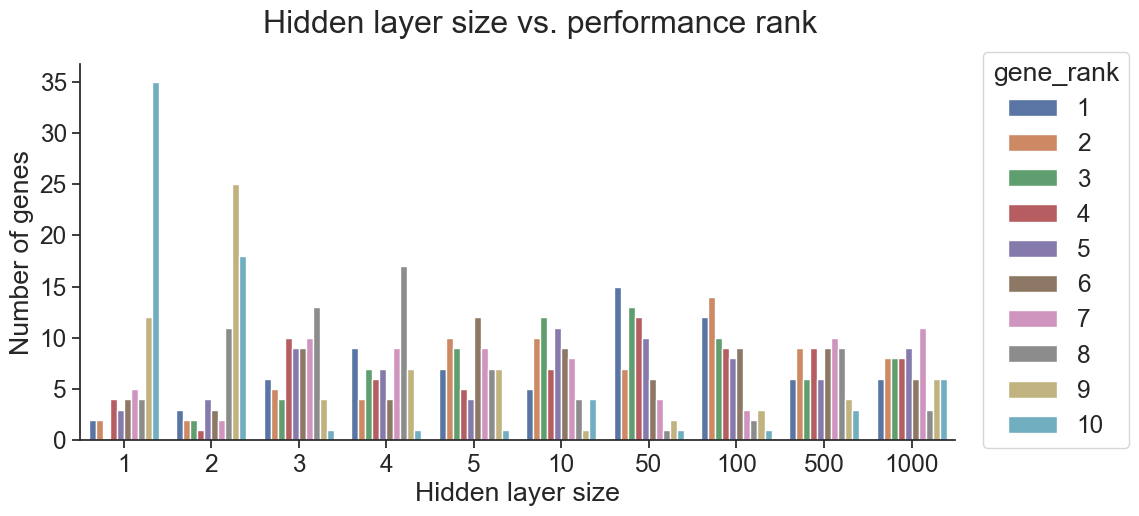

In [8]:
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.catplot(
        data=plot_rank_df, kind='bar',
        x='hsize', y='gene_count', hue='gene_rank', height=5, aspect=2.
    )
    g.set_xlabels('Hidden layer size')
    g.set_ylabels('Number of genes')
    plt.suptitle('Hidden layer size vs. performance rank', y=1.05)
    sns.move_legend(g, 'center right', bbox_to_anchor=(1.025, 0.57), frameon=True)

In [9]:
plot_upper_half_df = test_ranks_df.copy()
plot_upper_half_df['upper_half'] = (plot_upper_half_df.gene_rank > 5)

plot_upper_half_df = (plot_upper_half_df
    .groupby(['hsize', 'upper_half'])
    .count()
    .loc[:, ['gene']]
    .reset_index()
    .rename(columns={'gene': 'gene_count'})
)

plot_upper_half_df.hsize = plot_upper_half_df.hsize.astype(int)
plot_upper_half_df.sort_values(by=['hsize', 'upper_half'])

plot_upper_half_df.head()

,hsize,upper_half,gene_count
0,1,False,11
1,1,True,60
2,10,False,45
3,10,True,26
4,100,False,53


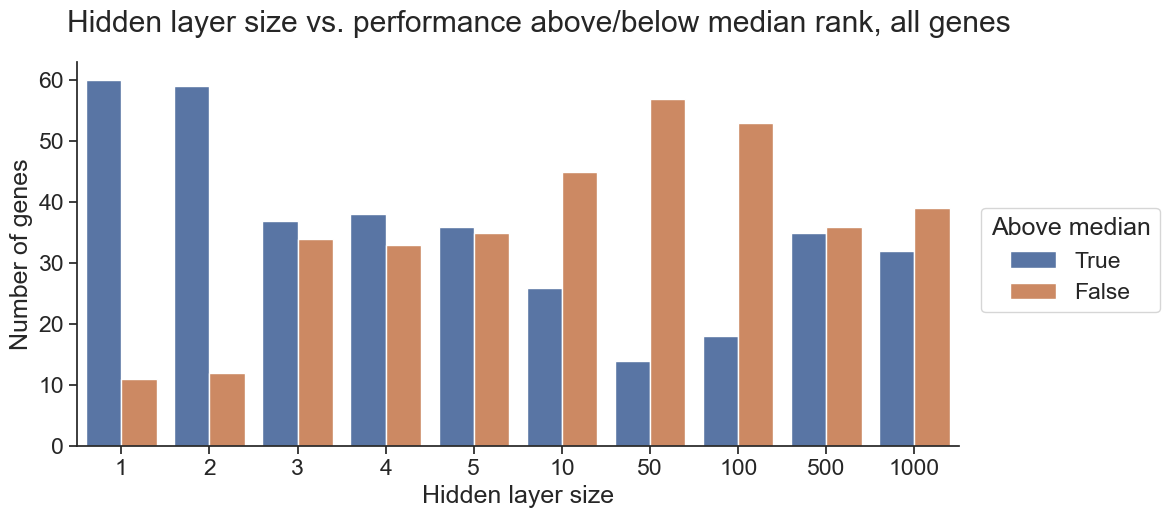

In [10]:
sns.set({'figure.figsize': (8, 3)})
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.catplot(
        data=plot_upper_half_df, kind='bar',
        x='hsize', y='gene_count', hue='upper_half',
        hue_order=[True, False], height=5, aspect=2.
    )
    g.set_xlabels('Hidden layer size')
    g.set_ylabels('Number of genes')
    plt.suptitle('Hidden layer size vs. performance above/below median rank, all genes', y=1.05)
    g._legend.set_title('Above median')
    sns.move_legend(g, 'center right', bbox_to_anchor=(1.055, 0.55), frameon=True)
    
if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'all_nn_hsize_above_below_median.svg'), bbox_inches='tight')

### Get "best" hidden layer size and compare performance across all genes

We want to use two different strategies to pick the "best" hidden layer size:

1. Choose the top 25% of hsizes based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "parsimonious" approach that assumes that smaller models will generalize better.
2. Choose the top hsize parameter based solely on validation set AUPR, without considering model size. This is the "non-parsimonious" approach.

We'll do this for each gene/cancer type in the dataset, and plot the distribution of differences between the two strategies, as a way to quantify which strategy is "better" for generalization across cancer types.

In [11]:
def get_top_and_smallest_diff(gene, top_proportion=0.25):
    top_df = (
        hsize_df[(hsize_df.gene == gene) &
                 (hsize_df.data_type == 'cv') &
                 (hsize_df.signal == 'signal')]
          .groupby(['hsize'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    rank_cutoff = ceil(hsize_df.hsize.unique().shape[0] * top_proportion)
    params_above_cutoff = top_df.loc[top_df.aupr_rank <= rank_cutoff, :].index

    # get parameter with best validation performance
    top_hsize = params_above_cutoff[0]

    # get smallest hsize in top 5 validation performance
    smallest_hsize = params_above_cutoff.min()

    holdout_df = (
        hsize_df[(hsize_df.gene == gene) &
                 (hsize_df.data_type == 'test') &
                 (hsize_df.signal == 'signal')]
          .groupby(['hsize'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
    )

    top_smallest_diff = (
        holdout_df.loc[top_hsize, 'mean_aupr'] -
        holdout_df.loc[smallest_hsize, 'mean_aupr']
    )
    return [gene, top_hsize, smallest_hsize, top_smallest_diff]

print(get_top_and_smallest_diff('SETD2'))

['SETD2', '10', '10', 0.0]


In [12]:
all_top_smallest_diff_df = []

for gene in hsize_df.gene.unique():
    all_top_smallest_diff_df.append(get_top_and_smallest_diff(gene))
        
all_top_smallest_diff_df = pd.DataFrame(
    all_top_smallest_diff_df,
    columns=['gene', 'top_hsize', 'smallest_hsize', 'top_smallest_diff']
)
all_top_smallest_diff_df['best'] = 'top'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff < 0, 'best'
] = 'smallest'
all_top_smallest_diff_df.loc[
    all_top_smallest_diff_df.top_smallest_diff == 0, 'best'
] = 'zero'

print(all_top_smallest_diff_df.best.value_counts())
all_top_smallest_diff_df.head()

top         28
zero        22
smallest    21
Name: best, dtype: int64


,gene,top_hsize,smallest_hsize,top_smallest_diff,best
0,TP53,5,100,0.004255,top
1,KDM5C,1000,100,-0.003140,smallest
2,RB1,10,10,0.000000,zero
3,CIC,50,1000,0.010602,top
4,BRAF,10,10,0.000000,zero


In [13]:
(all_top_smallest_diff_df
  .sort_values(by='top_smallest_diff', ascending=False)
  .to_csv(cfg.generalization_data_dir / f'tcga_ccle_nn_best_vs_smallest.tsv', sep='\t')
)

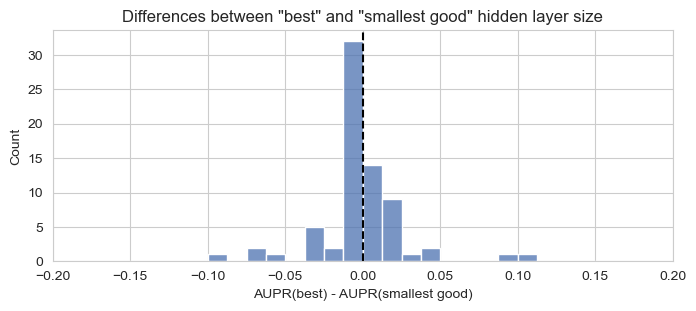

In [14]:
sns.set({'figure.figsize': (8, 3)})
sns.set_style('whitegrid')

sns.histplot(all_top_smallest_diff_df.top_smallest_diff, binwidth=0.0125, binrange=(-0.2, 0.2))
plt.xlim(-0.2, 0.2)
plt.title('Differences between "best" and "smallest good" hidden layer size')
plt.xlabel('AUPR(best) - AUPR(smallest good)')
plt.gca().axvline(0, color='black', linestyle='--')

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'all_nn_best_vs_smallest.svg'), bbox_inches='tight')

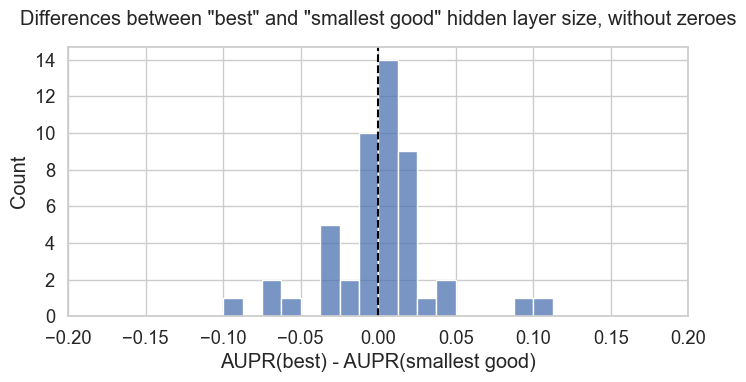

In [15]:
sns.set({'figure.figsize': (8, 3.5)})
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=1.2):
    sns.histplot(
        all_top_smallest_diff_df[all_top_smallest_diff_df.top_smallest_diff != 0.0].top_smallest_diff,
        binwidth=0.0125, binrange=(-0.2, 0.2)
    )
    plt.xlim(-0.2, 0.2)
    plt.title('Differences between "best" and "smallest good" hidden layer size, without zeroes', y=1.05)
    plt.xlabel('AUPR(best) - AUPR(smallest good)')
    plt.gca().axvline(0, color='black', linestyle='--')

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'all_nn_best_vs_smallest_no_zeroes.svg'), bbox_inches='tight')

In [16]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=False).head(10)

,gene,top_hsize,smallest_hsize,top_smallest_diff,best
34,FBXW7,500,10,0.108737,top
6,ARID2,5,3,0.093765,top
21,ERBB2,50,100,0.042375,top
33,FGFR2,3,1,0.038052,top
9,PBRM1,4,100,0.025852,top
24,AXIN1,100,10,0.024370,top
43,SMAD2,50,4,0.022585,top
20,NRAS,50,1000,0.022440,top
8,NPM1,500,5,0.017830,top
61,NF1,5,10,0.017460,top


In [17]:
all_top_smallest_diff_df.sort_values(by='top_smallest_diff', ascending=True).head(10)

,gene,top_hsize,smallest_hsize,top_smallest_diff,best
37,IDH2,50,1,-0.091030,smallest
49,NOTCH2,100,10,-0.071430,smallest
16,SMARCA4,4,10,-0.063885,smallest
69,JAK2,4,3,-0.057408,smallest
44,CTNNB1,500,1000,-0.036125,smallest
62,NFE2L2,50,10,-0.033608,smallest
28,STK11,50,100,-0.033450,smallest
57,BAP1,5,100,-0.029320,smallest
46,DNMT1,500,1000,-0.028202,smallest
70,EZH2,5,10,-0.021295,smallest
